# DMEYF - Trabajo Práctico 1

Autor: Ignacio Arrmesto

# Gradient Boosting Desicion Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.

Antes que nada, carguemos el entorno de trabajo


In [ ]:
%pip install scikit-learn==1.3.2
%pip install seaborn==0.13.1
%pip install numpy==1.26.4
%pip install matplotlib==3.7.1
%pip install pandas==2.1.4
%pip install lightgbm==4.4.0
%pip install optuna==3.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.
   ━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/DMEYF/TP1/'
dataset_path = base_path + 'datos/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202104
mes_test = 202106

# agregue sus semillas
semillas = [1,20,3,40,5]

data = pd.read_csv(dataset_path + dataset_file)

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [ ]:
data['clase_ternaria'].fillna('BAJA+2', inplace=True)


In [ ]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

Además, como se mencionó en la clase pasada, comenzaremos a experimentar con nuevas clases para ajustar el modelo. En particular, sumaremos la clase **BAJA+1**, que es estructuralmente muy similar a **BAJA+2**, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [ ]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [ ]:
valores_unicos = data['clase_ternaria'].unique()


In [ ]:
print(valores_unicos)

['CONTINUA' 'BAJA+2' 'BAJA+1']


Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

In [ ]:
data.head()

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,clase_ternaria,clase_peso,clase_binaria1,clase_binaria2
0,260486881,202101,1,0,0,57,85,2014.41,23213.40,2542.52,...,0.0,2573.0,6221.24,8.0,0.0,1982.37,CONTINUA,1.00000,0,0
1,260486881,202102,1,0,0,57,86,1505.51,22577.48,2180.71,...,0.0,2601.0,9857.83,9.0,0.0,2322.54,CONTINUA,1.00000,0,0
2,260486881,202103,1,0,0,57,87,2036.77,22402.20,3025.71,...,0.0,2632.0,16734.45,13.0,0.0,2369.46,CONTINUA,1.00000,0,0
3,260486881,202104,1,0,0,58,88,1528.48,21838.44,3210.74,...,0.0,2662.0,12463.21,10.0,0.0,1876.80,CONTINUA,1.00000,0,0
4,260486881,202105,1,0,0,58,89,-3.90,20171.49,3229.02,...,0.0,2693.0,6695.06,8.0,0.0,2991.15,BAJA+2,1.00002,1,1


In [ ]:
train_data = data[data['foto_mes'] == mes_train]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

Y preparamos el *dataset* para poder usar el **rf** de una clase anterior.

In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
Xif = imp_mean.fit_transform(X_test)

Comenzaremos explicando el funcionamiento del protagonista de esta clase: **LightGBM**. Primero, partiremos con una revisión de cómo funciona el algoritmo en el que se basa, **XGBoost**. Para una introducción completa, puedes consultar este

https://xgboost.readthedocs.io/en/stable/tutorials/model.html.

Aunque en la cátedra no somos grandes seguidores de Josh Starmer y su canal *StatQuest*, reconozco que sus series sobre *Gradient Boosting* y *XGBoost* son excelentes recursos. Aquí te dejamos los enlaces a esas dos series que realmente valen la pena:

[Serie Gradient Boosting](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

[Serie XGBoost](https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ)

Finalmente, analizaremos las diferencias clave que ofrece **LightGBM** frente a XGBoost. Puedes explorar más sobre ello en este https://lightgbm.readthedocs.io/en/stable/Features.html.

No olvides tener a mano la [documentación de LightGBM](https://lightgbm.readthedocs.io/)y la [lista completa de sus parámetros](https://lightgbm.readthedocs.io/en/latest/Parameters.html).

Este es un algoritmo muy usado en el mercado, recomiendo dedicarle el tiempo necesario para aprenderlo bien.

Vamos a utilizar el algoritmo directamente, sin pasar por *scikit-learn*. Sin embargo, si algún alumno lo prefiere, puede optar por usar el *wrapper* de sklearn para este caso.

Para evaluar la calidad del modelo, crearemos nuestra propia función de evaluación que calcule la ganancia. La razón de incluir los pesos es precisamente para poder implementar esta función de evaluación de manera adecuada. Al combinar las clases *BAJA+1* y *BAJA+2* en una sola, necesitamos una forma de diferenciarlas, y es aquí donde entra en juego el *weight*. Este parámetro nos permitirá distinguir entre ambas clases al momento de evaluarlas dentro del algoritmo.


In [ ]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

LGBM necesita su propio tipo de Datasets:

In [ ]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función **cv** que viene *out-of-the-box*

In [ ]:
cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

Y vizualizamos los resultados de ambas ejecuciones:

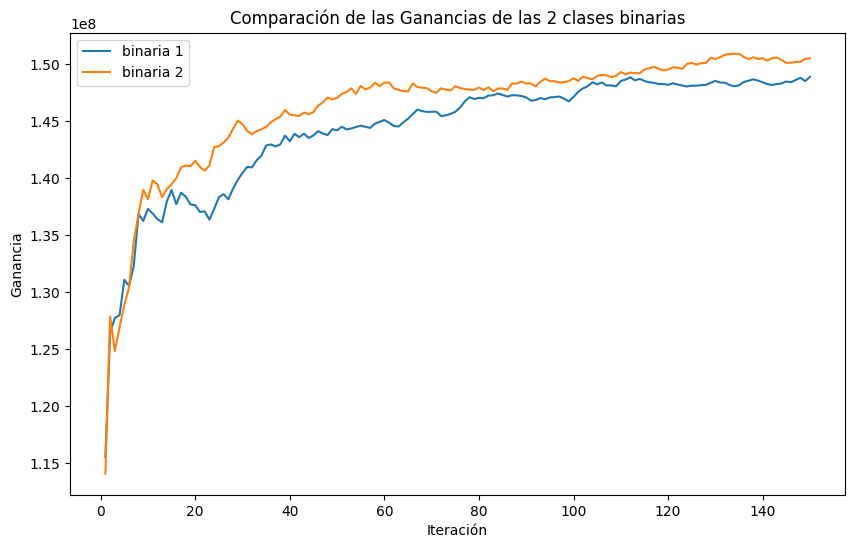

In [ ]:
df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


Se observa una ligera mejora al combinar las clases en modelos sencillos. Dado que cada pequeña mejora es importante, continuaremos utilizando esta estrategia.

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**. Cabe destacar que las optimizaciones que realizaremos son básicas y están diseñadas para ejecutarse en pocos minutos. Será su responsabilidad ampliar tanto el rango de búsqueda como el tiempo de optimización para obtener un modelo más competitivo.


In [ ]:

def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_301_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-12 19:14:14,037] Using an existing study with name 'exp_301_lgbm' instead of creating a new one.


In [ ]:
new_var = study.optimize(objective, n_trials=100)
new_var

[I 2024-10-12 19:17:38,753] Trial 102 finished with value: 153636000.0 and parameters: {'num_leaves': 86, 'learning_rate': 0.09561823498675875, 'min_data_in_leaf': 887, 'feature_fraction': 0.6654757017388652, 'bagging_fraction': 0.2959359341335117}. Best is trial 38 with value: 158039000.0.
[I 2024-10-12 19:18:33,713] Trial 103 finished with value: 155939000.0 and parameters: {'num_leaves': 82, 'learning_rate': 0.1038777946973658, 'min_data_in_leaf': 798, 'feature_fraction': 0.7640383661469637, 'bagging_fraction': 0.27561107589919676}. Best is trial 38 with value: 158039000.0.
[I 2024-10-12 19:19:25,727] Trial 104 finished with value: 154476000.0 and parameters: {'num_leaves': 62, 'learning_rate': 0.08198185512307321, 'min_data_in_leaf': 956, 'feature_fraction': 0.609155751202655, 'bagging_fraction': 0.9926627043543941}. Best is trial 38 with value: 158039000.0.
[I 2024-10-12 19:20:19,146] Trial 105 finished with value: 153902000.0 and parameters: {'num_leaves': 58, 'learning_rate': 0.

Analizamos los resultados as usual

In [58]:
optuna.visualization.plot_optimization_history(study)

In [59]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [60]:
plot_slice(study)

In [61]:
plot_contour(study)

Output hidden; open in https://colab.research.google.com to view.

In [62]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [63]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 70
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Observamos la variables más importantes para el modelo:

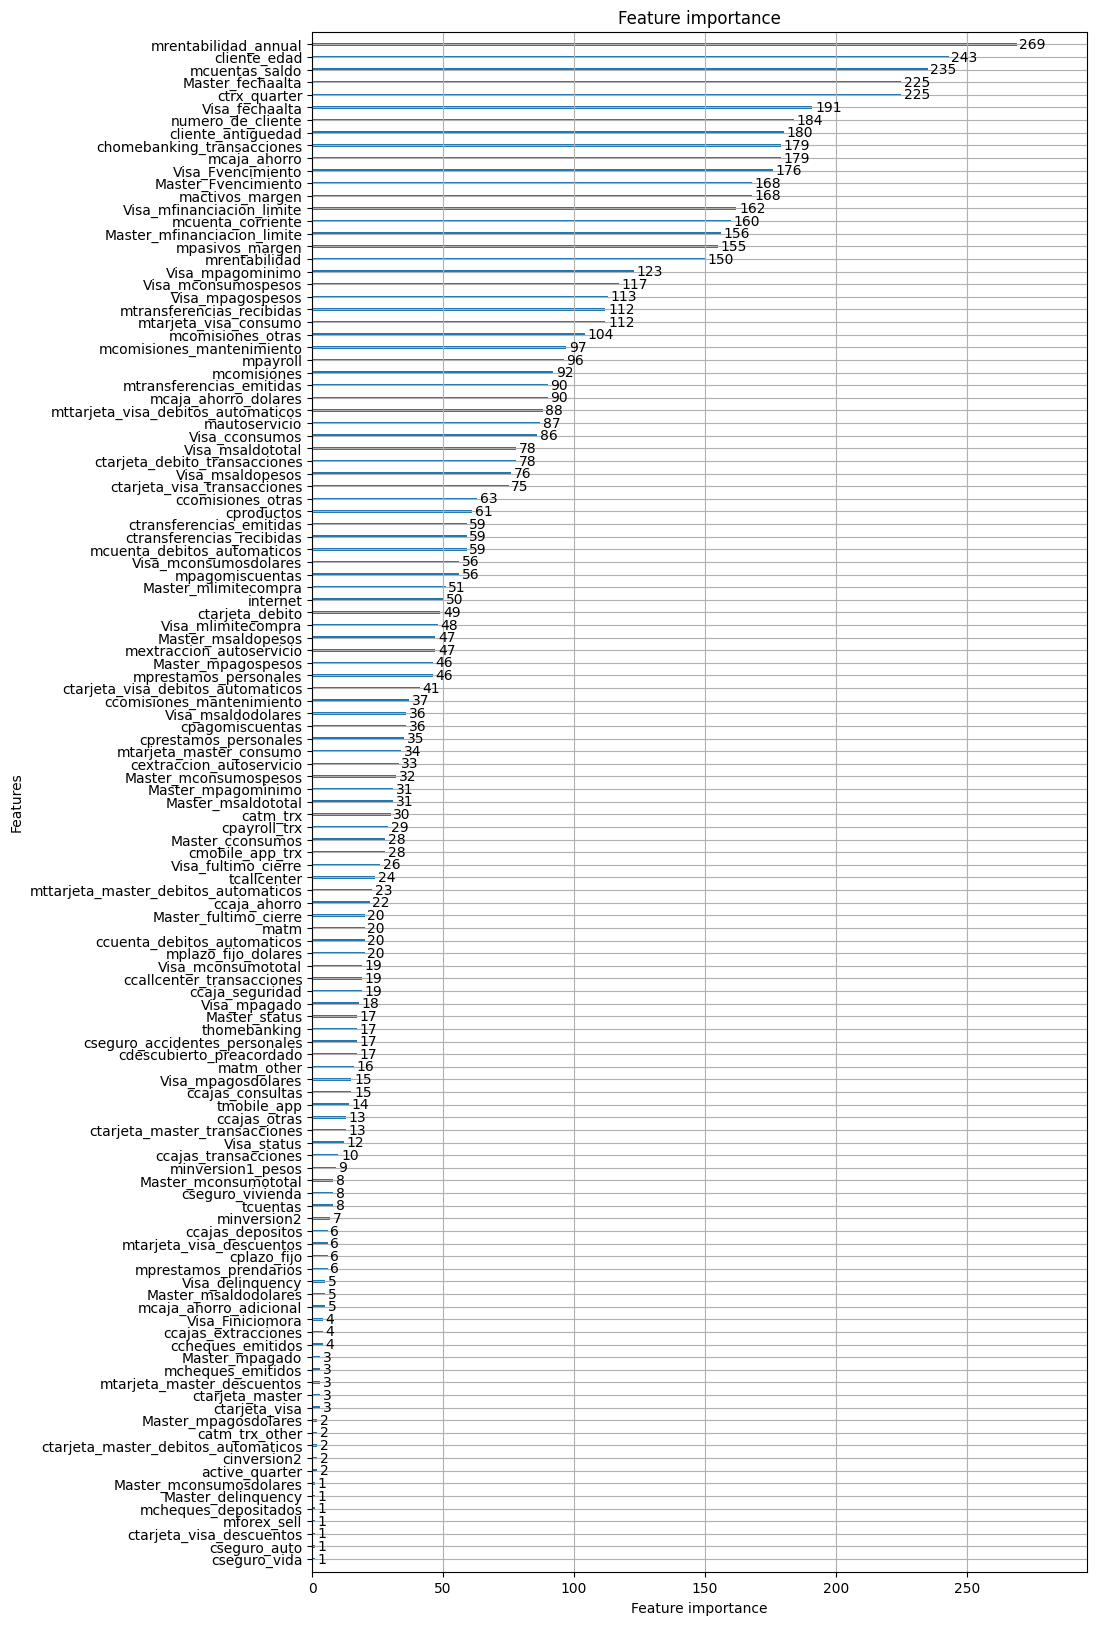

In [64]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [65]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


,feature,importance
8,mrentabilidad_annual,269
5,cliente_edad,243
22,mcuentas_saldo,235
107,ctrx_quarter,225
127,Master_fechaalta,225
...,...,...
46,cseguro_vida,1
87,mcheques_depositados,1
110,Master_delinquency,1
79,mforex_sell,1


Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [68]:
model.save_model(modelos_path + 'lgb_first.txt')

Y recuperar el mismo desde ese formato

In [69]:
model = lgb.Booster(model_file=modelos_path + 'lgb_first.txt')

Y sobre ambos modelos obtenemos la predicción de **Abril**

In [70]:
y_pred_lgm = model.predict(X_test)

In [71]:
print(y_pred_lgm)

[8.85435583e-03 7.13483735e-04 4.58939684e-04 ... 9.59090131e-05
 4.08073687e-05 1.93168844e-02]


In [72]:
# Supongamos que 'X_test' es tu DataFrame original del que deseas conservar el resto
y_pred_prob = model.predict(X_test)

# Convertir a predicciones binarias usando un umbral de 0.025
threshold = 0.025
y_pred_binary = (y_pred_prob >= threshold).astype(int)

# Agregar las columnas de probabilidades y predicciones al DataFrame original
X_test['probabilidad'] = y_pred_prob
X_test['prediccion'] = y_pred_binary

# Ver las primeras filas del DataFrame original con las nuevas columnas
print(X_test.head(20))  # Muestra las primeras 20 filas


     numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
5            260486881    202106               1            0         0   
11           260993722    202106               1            0         0   
17           264682375    202106               1            0         0   
23           277365853    202106               1            0         0   
29           277813549    202106               1            0         0   
35           281626830    202106               1            0         0   
41           289097842    202106               1            0         0   
47           291684571    202106               1            0         0   
53           294788055    202106               1            0         0   
54           307738733    202106               1            0         0   
60           308112338    202106               1            0         0   
66           311331194    202106               1            0         0   
72           316060730   

In [73]:
print(X_test.tail(20))


        numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
981836          608335191    202106               1            0         0   
981842          613286572    202106               1            0         2   
981848          613568588    202106               1            0         0   
981854          615037405    202106               1            0         0   
981860          621788193    202106               1            0         0   
981866          627779295    202106               1            0         0   
981872          636983711    202106               1            0         0   
981878          639839612    202106               1            0         0   
981884          640069476    202106               1            0         0   
981890          642522668    202106               1            0         0   
981896          646982963    202106               1            0         0   
981904          648991303    202106               1            0

In [ ]:
# valores_unicos_prediccion = predictions_df['prediccion'].unique()
# print("Valores únicos de prediccion:", valores_unicos_prediccion)

NameError: name 'predictions_df' is not defined

In [74]:
X_test.prediccion.value_counts()

,count
prediccion,
0,151313
1,13563


In [75]:
# Filtrar el DataFrame para quedarte solo con 'numero_de_cliente' y 'prediccion'
result_df = X_test[['numero_de_cliente', 'prediccion']]

# Renombrar la columna 'prediccion' a 'Predicted' si es necesario
result_df.rename(columns={'prediccion': 'Predicted'}, inplace=True)

# Ver las primeras filas del DataFrame resultante
print(result_df.head())


    numero_de_cliente  Predicted
5           260486881          0
11          260993722          0
17          264682375          0
23          277365853          0
29          277813549          0


<ipython-input-75-371c4448d151>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [76]:
# Especificar la ruta completa del archivo donde deseas guardar el DataFrame
output_file = dataset_path + "resultados_predicciones.csv"

# Guardar el DataFrame como un archivo CSV en la ruta especificada
result_df.to_csv(output_file, index=False)

In [ ]:
# y_pred_rf = model_rf_1000.predict_proba(Xif)
# y_pred_rf = y_pred_rf[:,1] # adaptamos la salida para que sea homogénea con el LGBM

# y_pred_lgm = model.predict(X_test)

NameError: name 'model_rf_1000' is not defined